In [1]:
!pip install torch torchvision


# important library:

In [2]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image , ImageDraw 
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor



# load train data:

In [3]:
train = pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")
train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


- split the bbox column to x1,y1,w,h

In [4]:
coord = pd.DataFrame(list(train.bbox.apply(lambda x : x[1:-1].split(",")).values),columns=["x1","y1","w","h"])

In [5]:
df = pd.concat([train,coord],axis=1)

- make the values of the columns numeric values:

In [6]:
df['x1']=pd.to_numeric(df['x1'])
df['y1']=pd.to_numeric(df['y1'])
df['w']=pd.to_numeric(df['w'])
df['h']=pd.to_numeric(df['h'])


- calcualte the y2,x2 :

In [7]:
df['x2']=df['x1']+df['w']
df['y2']=df['y1']+df['h']

In [8]:
df

,image_id,width,height,bbox,source,x1,y1,w,h,x2,y2
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,890.0,258.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,356.0,606.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,451.0,664.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,943.0,202.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,150.0,261.0
...,...,...,...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2,64.0,619.0,84.0,95.0,148.0,714.0
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2,292.0,549.0,107.0,82.0,399.0,631.0
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2,134.0,228.0,141.0,71.0,275.0,299.0
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2,430.0,13.0,184.0,79.0,614.0,92.0


- Drop unneeded column:

In [9]:
df.drop(['bbox','width','height','w','h','source'],axis=1,inplace=True)

In [10]:
df.head()

,image_id,x1,y1,x2,y2
0,b6ab77fd7,834.0,222.0,890.0,258.0
1,b6ab77fd7,226.0,548.0,356.0,606.0
2,b6ab77fd7,377.0,504.0,451.0,664.0
3,b6ab77fd7,834.0,95.0,943.0,202.0
4,b6ab77fd7,26.0,144.0,150.0,261.0


- Take the unique ids of the images:

In [11]:
unique_imgs=df.image_id.unique()
unique_imgs

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb', ..., 'a5c8d5f5c',
       'e6b5e296d', '5e0747034'], dtype=object)

- Make custom class for preparing the data:

In [12]:
class custDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]
        boxes = self.df[self.df.image_id == image_name].values[:, 1:].astype("float")
        img = Image.open("../input/global-wheat-detection/train/" + image_name + ".jpg").convert('RGB')
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["label"] = labels
        return T.ToTensor()(img), target


# spit the data int train and validation:

In [13]:
train_inds , val_inds =train_test_split(range(unique_imgs.shape[0]),test_size=0.1)

In [14]:
def custom_collate(data):
    return data

# Call the data loader to prepare it to the model:

In [15]:
train_dl = torch.utils.data.DataLoader(custDat(df,unique_imgs,train_inds),batch_size=16,shuffle=True,collate_fn=custom_collate,pin_memory=True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(custDat(df,unique_imgs,val_inds),batch_size=8,shuffle=True,collate_fn=custom_collate,pin_memory=True if torch.cuda.is_available() else False)


# Modeling:

In [16]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes=2
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor =  FastRCNNPredictor(in_features,num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 165MB/s]  


In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [18]:
device

device(type='cuda')

In [19]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.005)
num_epochs=5

_ train the model with 5 epochs and prin the loss:

In [20]:
model.to(device)
for epochs in range (num_epochs):
    epoch_loss = 0
    for data in train_dl:
        imgs=[]
        targets = []
        for d in data :
            imgs.append(d[0].to(device))
            targ = {}
            targ['boxes']=d[1]['boxes'].to(device)
            targ['labels']=d[1]['label'].to(device)
            targets.append(targ)
        loss_dict = model(imgs,targets)
        loss= sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch_loss) 
            
            

213.50475181699883
168.9601131403356
161.09055540505196
156.55169284023506
152.99538488691513


- Evaluate the model

In [21]:
model.eval()
data = iter(val_dl).__next__()

In [22]:
img= data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['label']

In [23]:
output = model([img.to(device)])


- output os the evaluation:

In [24]:
output

[{'boxes': tensor([[9.1541e+02, 3.8329e+02, 9.9253e+02, 4.7464e+02],
          [5.3927e+02, 5.4922e+01, 6.2188e+02, 1.5302e+02],
          [6.4744e+02, 2.4210e+01, 7.3412e+02, 1.4454e+02],
          [6.1762e+02, 6.2132e+02, 7.0491e+02, 7.0311e+02],
          [7.2354e+02, 4.7412e+02, 8.0229e+02, 5.4692e+02],
          [9.3192e+02, 2.7911e+02, 1.0219e+03, 3.7232e+02],
          [6.5686e+02, 3.2208e+02, 7.5093e+02, 4.1259e+02],
          [8.4205e+02, 7.7617e+02, 9.2086e+02, 8.5666e+02],
          [6.1414e+02, 2.2011e+02, 6.9031e+02, 2.8588e+02],
          [9.4748e+02, 2.3562e+02, 1.0210e+03, 3.0921e+02],
          [7.6291e+02, 4.0916e+02, 8.5806e+02, 5.0982e+02],
          [8.2350e+02, 5.8158e+02, 8.9416e+02, 6.7172e+02],
          [7.3836e+02, 2.6077e+02, 8.2503e+02, 3.7190e+02],
          [6.1474e+02, 2.7630e+02, 7.0073e+02, 3.4515e+02],
          [5.8222e+02, 0.0000e+00, 6.5888e+02, 6.4488e+01],
          [9.4442e+02, 4.5175e+02, 1.0155e+03, 5.2809e+02],
          [8.8309e+02, 5.9490e+

In [25]:
out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

In [26]:
keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

In [27]:
out_bbox.shape , keep.shape

(torch.Size([51, 4]), torch.Size([36]))

- prediction detection:

In [32]:
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')
im

array([[[ 39,  32,   3],
        [ 37,  30,   1],
        [ 40,  33,   5],
        ...,
        [ 57,  70,  50],
        [ 68,  83,  64],
        [ 73,  88,  69]],

       [[ 36,  29,   1],
        [ 34,  27,   0],
        [ 37,  30,   2],
        ...,
        [ 60,  73,  53],
        [ 72,  87,  68],
        [ 78,  93,  74]],

       [[ 31,  24,   0],
        [ 29,  22,   0],
        [ 33,  26,   0],
        ...,
        [ 62,  75,  55],
        [ 75,  88,  70],
        [ 81,  94,  76]],

       ...,

       [[ 36,  27,   0],
        [ 46,  37,   4],
        [ 77,  71,  39],
        ...,
        [ 91, 100,  73],
        [ 87,  96,  69],
        [ 85,  94,  67]],

       [[ 36,  26,   0],
        [ 48,  39,   6],
        [ 82,  76,  44],
        ...,
        [ 85,  90,  67],
        [100, 106,  80],
        [ 99, 105,  79]],

       [[ 32,  22,   0],
        [ 46,  38,   2],
        [ 84,  75,  44],
        ...,
        [ 88,  93,  70],
        [105, 111,  85],
        [ 96, 102,  76]]

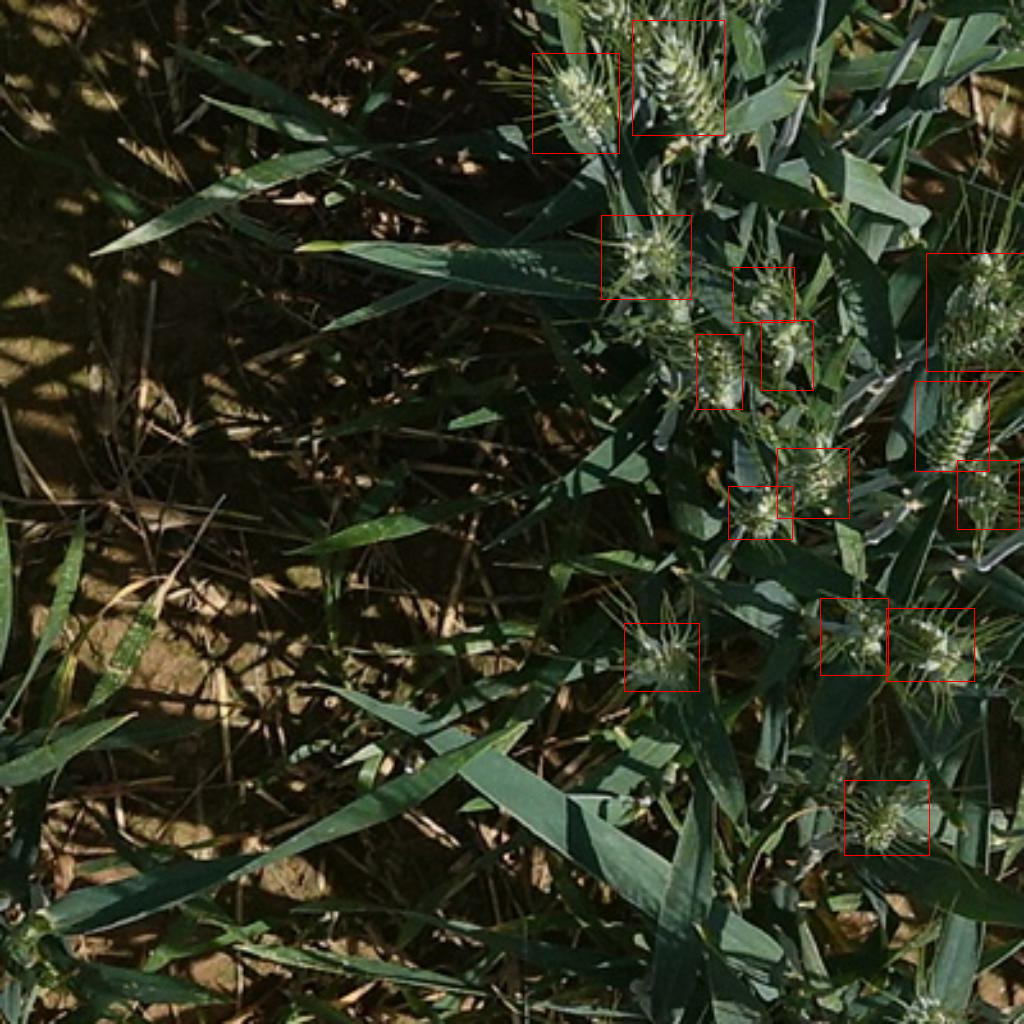

In [33]:
vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes :
    draw.rectangle(list(box),fill=None,outline='red')
vsample

# if you like it please upvote....